# Ensemble learning
Tutorial pokrywa najbardziej popularne metody uczenia zespołowego w oparciu o problem klasyfikacji.

Prezentacja dostępna pod linkiem: https://docs.google.com/presentation/d/102wXkjtPx06q1AxpQK76ytD0gamjus-leKIWr7xzjDk/edit?usp=sharing  
Dokumentacja używanych metod: https://scikit-learn.org/stable/modules/ensemble.html

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score

### Używając PCA transformujemy podzbiór MNIST do przestrzeni 30D

In [3]:
mnist = fetch_openml("mnist_784", data_home="data/mnist_784", cache=True)

In [4]:
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)

In [5]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

### Wybieramy ze zbioru dwie trudno rozdzielalne klasy. Będą to zbiory danych do następnych ćwiczeń.

In [6]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)

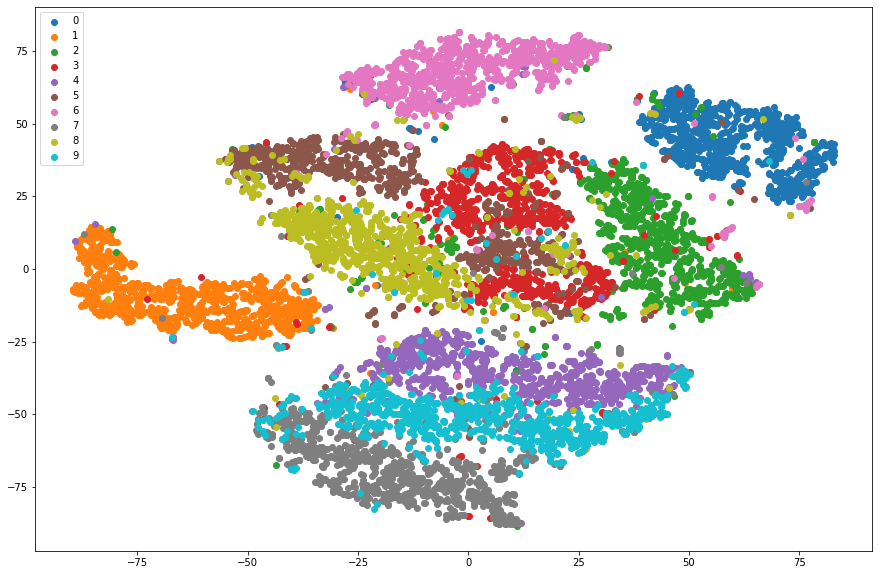

In [7]:
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

Jak widać na powyższym wykresie istnieją klasy, które wzajemnie na siebie nachodzą.  
Przykładem mogą być:  
    - 3 i 8  
    - 3 i 5  
    - 5 i 8  
    - 4 i 9  
    - 7 i 9  
Do dalszych zadań wybieramy klasę 3 i 8 

In [8]:
digit_filter = np.where((y == '3') | (y == '8'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1590, 30)

## Bagging

Każdy z 5 klasyfikatorów jest trenowany za pomocą pozdbioru o wielkości 40% calego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [10]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9723618090452262

Definujemy fukncje pomocnicze do obliczania wyników klasyfikacji oraz ich graficznej prezentacji

In [11]:
def ensemble(Clf, estimators=[5], samples=[0.9], features=[0.9], params={}):
    result = pd.DataFrame(columns=['n_estimators', 'max_features', 'max_samples', 'score_f1', 'score'])
    for n_estimators in estimators:
        for max_samples in samples:
            for max_features in features:
                clf = Clf(max_features=max_features, n_estimators=n_estimators, max_samples=max_samples, **params)
                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)
                row = { 'n_estimators':n_estimators,
                        'max_samples':max_samples,
                        'max_features':max_features,
                        'score': clf.score(x_test, y_test),
                        'score_f1': f1_score(y_test, pred, average='weighted')
                      }
                result = result.append(row, ignore_index=True)
    return result

    
def draw_heatmap(param1, param2, df, score='score'):
    score = df.pivot(param1, param2, score)
    plt.figure(figsize=(10,10))
    sns.heatmap(score,annot=True, cmap='coolwarm')

Obserwujemy zmianę dokładności klasyfikacji i F1 dla wzrastającej liczby klasyfikatorów w zespole i liczby przykładów, na których uczone są klasyfikatory proste.

In [12]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.967332,0.967337
1,5.0,0.9,0.2,0.967332,0.967337
2,5.0,0.9,0.3,0.969849,0.969849
3,5.0,0.9,0.4,0.967341,0.967337
4,5.0,0.9,0.5,0.974881,0.974874
...,...,...,...,...,...
95,50.0,0.9,0.6,0.974881,0.974874
96,50.0,0.9,0.7,0.974881,0.974874
97,50.0,0.9,0.8,0.974881,0.974874
98,50.0,0.9,0.9,0.974881,0.974874


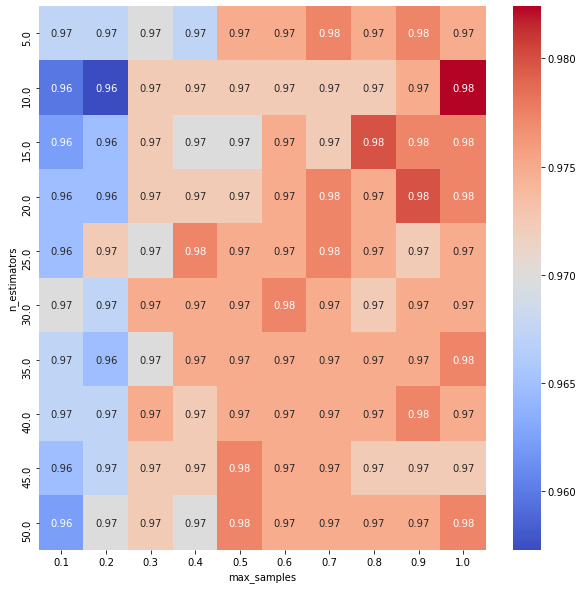

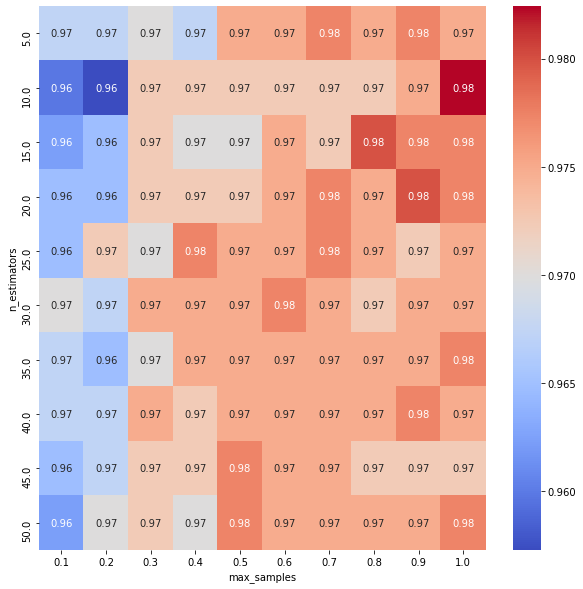

In [13]:
# dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik klasycznego baggingu z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [14]:
clf1 = BaggingClassifier(base_estimator=SVC(), n_estimators=50, max_samples=0.4, bootstrap=True) 
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('bagging', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('bagging hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('bagging svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('bagging', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('bagging soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('bagging svc soft',cc.score(x_test, y_test))

bagging hard 0.9723618090452262
svc hard 0.9773869346733668
bagging svc hard 0.9748743718592965
bagging soft 0.9748743718592965
svc soft 0.9773869346733668
bagging svc soft 0.9748743718592965


## Random Subspace
Do trenowania każdego z klasyfikatorów wykorzystany jest cały zbiór danych, lecz tylko połowa cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [15]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9522613065326633

Teraz obserwujemy zmienę dokładność klasyfikacji i F1 dla Random Subspace.

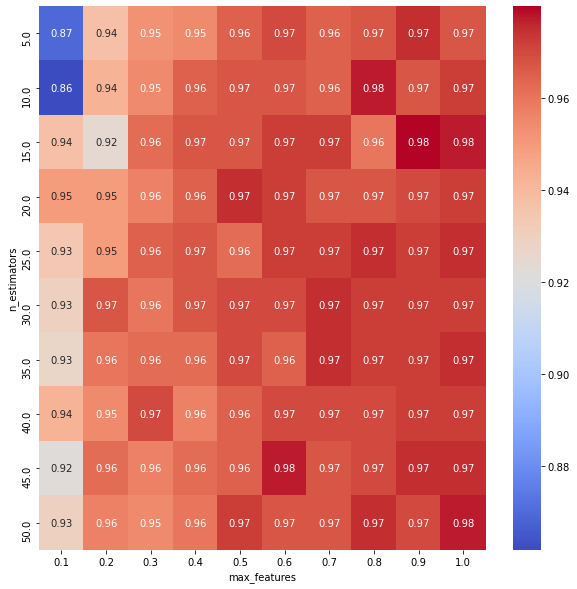

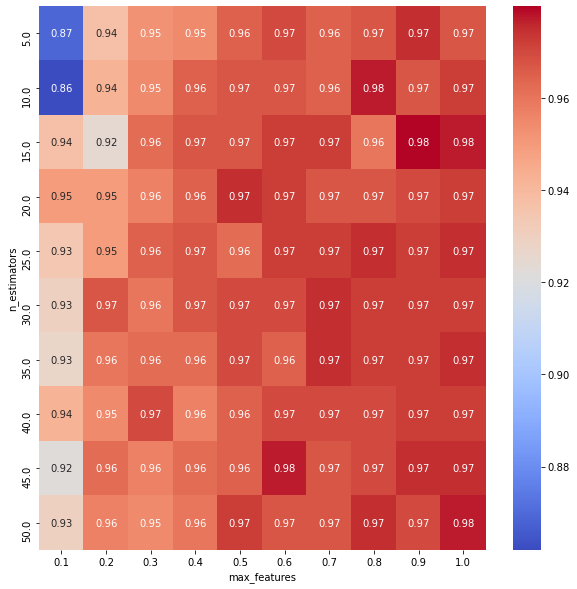

In [16]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik otrzymany dla random subspace z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [17]:
clf1 = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('randsubspace', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('randsubspace hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('randsubspace svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randsubspace', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('randsubspace soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('randsubspace svc soft',cc.score(x_test, y_test))

randsubspace hard 0.9748743718592965
svc hard 0.9773869346733668
randsubspace svc hard 0.9723618090452262
randsubspace soft 0.964824120603015
svc soft 0.9773869346733668
randsubspace svc soft 0.9698492462311558


## Random Patches
Jest to połączenie klasycznego Baggingu i RandomSubspace.

Każdy z klasyfikatorów jest trenowany na podzbiorze danych oraz podzbiorze cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


In [18]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.964824120603015

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 w zależności od wielkości podzbioru danych i cech.

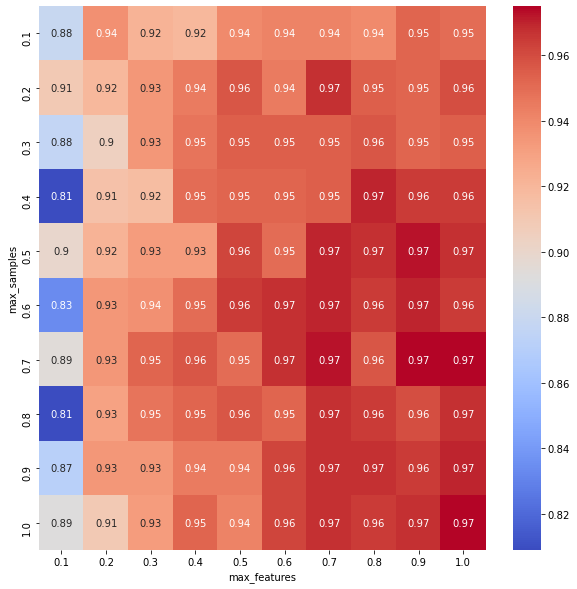

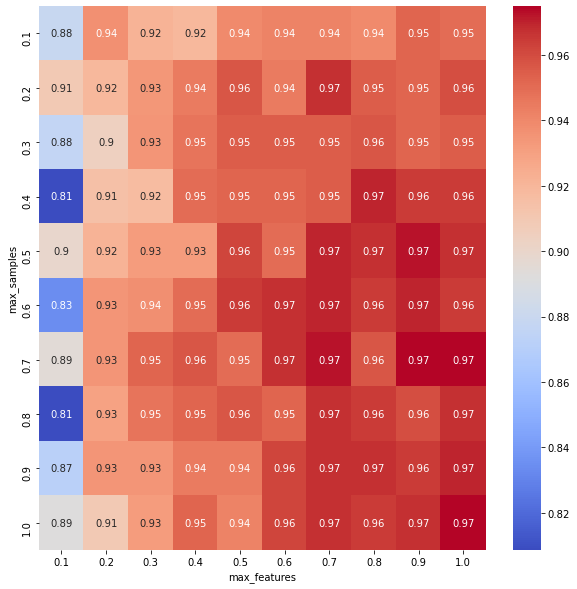

In [19]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik otrzymany dla random patches z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [20]:
clf1 = classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('randpatches', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('randpatches hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randpatches', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('randpatches svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randpatches', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('randpatches soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randpatches', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('randpatches svc soft',cc.score(x_test, y_test))

randpatches hard 0.9346733668341709
svc hard 0.9773869346733668
randpatches svc hard 0.9748743718592965
randpatches soft 0.9346733668341709
svc soft 0.9773869346733668
randpatches svc soft 0.964824120603015


## AdaBoost
Jest to metoda, która dla nowo tworzonych kopi klasyfikatorów uwzględnia dodatkowo wagi nieprawidłowo sklasyfikowanych instancji, tak aby mogły się one skoncentrować na bardziej skomplikowanych przypadkach.  
Domyślnie jako klasyfikator bazowy używany jest DecisionTreeClassifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [18]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9022556390977443

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla AdaBoost.

In [19]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.902256,0.902209
1,10.0,0.939850,0.939871
2,15.0,0.947368,0.947387
3,20.0,0.944862,0.944881
4,25.0,0.952381,0.952397
5,30.0,0.952381,0.952396
6,35.0,0.954887,0.954903
7,40.0,0.967419,0.967429
8,45.0,0.967419,0.967430
9,50.0,0.967419,0.967429


In [20]:
result.score.max(), result.score.idxmax()

(0.9674185463659147, 7)

In [21]:
result.score_f1.max(), result.score_f1.idxmax()

(0.9674300117159182, 8)

## Random Forest
Jest to metoda oparta o las drzew uczących. Każde z nich uczone jest na losowo wybranym podzbiorze danych wraz z podzbiorem cech. Skutkuje to zmniejszoną korelacją pomiędzy poszczególnymi drzewami.  
Poniżej przedstawiono wynik klasyfikacji dla 5 klasyfikatorów oraz zbiorze cech równym połowie początkowego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [22]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9373433583959899

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla Random Forest.


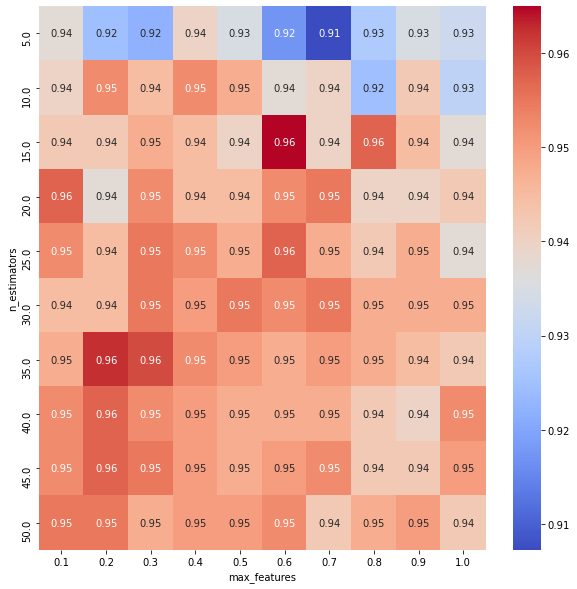

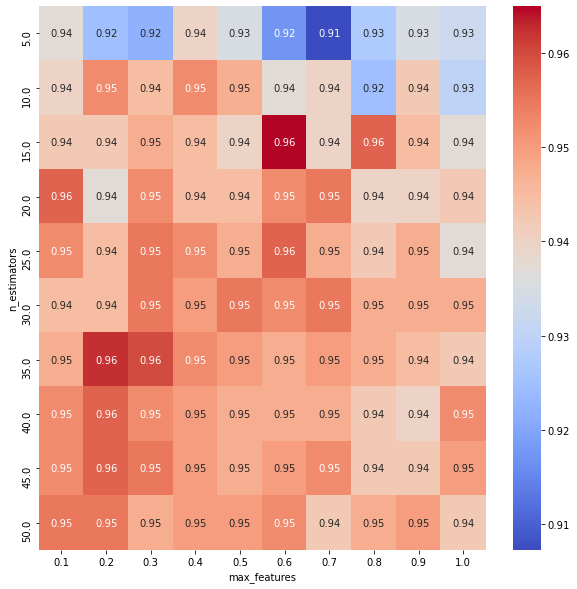

In [23]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

## Zadanie indywidualne

1. Przetransformować zbiór FMNIST używając PCA do przestrzeni 30D. Następnie wybrać 2 trudno rozdzielane klasy

In [24]:
import tensorflow as tf
from sklearn.utils import resample
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x,y = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)
x = x.reshape(10000,-1)

In [25]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

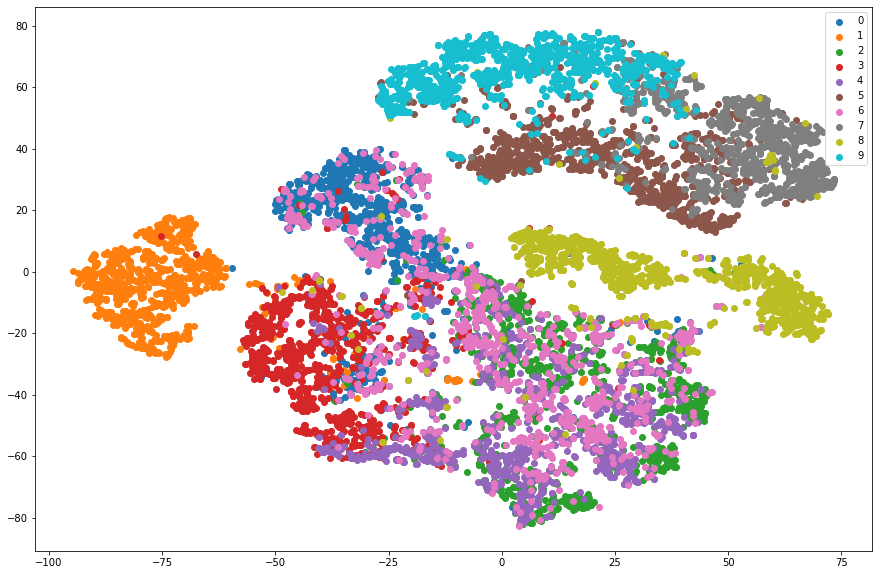

In [26]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [i for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

In [27]:
digit_filter = np.where((y == 2) | (y == 4))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1629, 30)

2. Sprawdzić jak działa klasyczny Bagging dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru danych, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [28]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8651960784313726

In [29]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.828514,0.828431
1,5.0,0.9,0.2,0.848167,0.848039
2,5.0,0.9,0.3,0.862861,0.862745
3,5.0,0.9,0.4,0.867762,0.867647
4,5.0,0.9,0.5,0.872659,0.872549
...,...,...,...,...,...
95,50.0,0.9,0.6,0.867711,0.867647
96,50.0,0.9,0.7,0.872632,0.872549
97,50.0,0.9,0.8,0.879999,0.879902
98,50.0,0.9,0.9,0.882443,0.882353


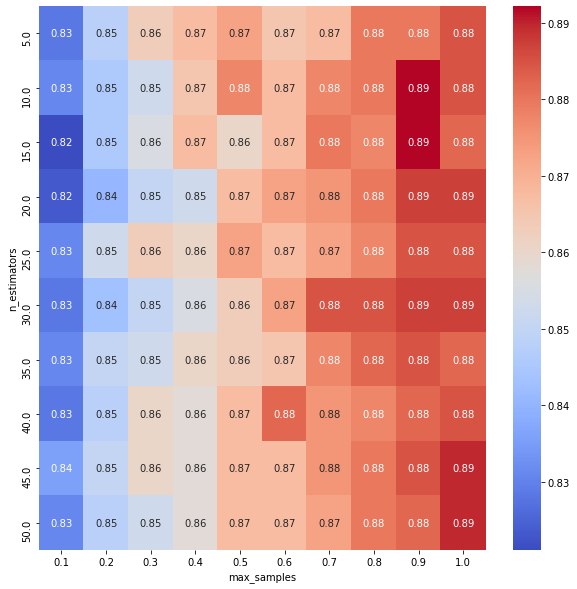

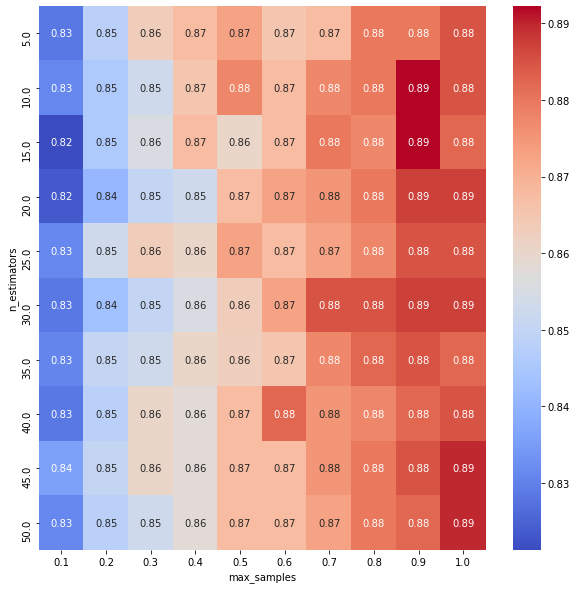

In [30]:
# dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')

In [32]:
from sklearn.naive_bayes import GaussianNB

clf1 = BaggingClassifier(base_estimator=SVC(), n_estimators=50, max_samples=0.4, bootstrap=True) 
clf2 = SVC(probability=True)
clf3 = GaussianNB()

c = VotingClassifier(estimators=[('bagging', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('bagging hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('bagging svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2),('gnb', clf3)], voting='hard')
cc = c.fit(x_train, y_train)
print('bagging svc gnb hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('bagging', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('bagging soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('bagging svc soft',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('bagging', clf1),('svc', clf2),('gnb', clf3)], voting='soft')
cc = c.fit(x_train, y_train)
print('bagging svc gnb soft',cc.score(x_test, y_test))

bagging hard 0.8651960784313726
svc hard 0.8848039215686274
bagging svc hard 0.875
bagging svc gnb hard 0.875
bagging soft 0.875
svc soft 0.8799019607843137
bagging svc soft 0.8725490196078431
bagging svc gnb soft 0.8602941176470589


3. Sprawdzić jak działa RandomSubspace dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [33]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8504901960784313

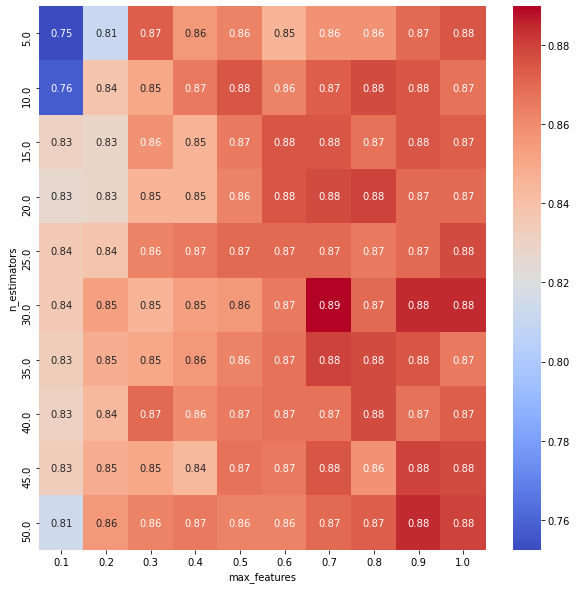

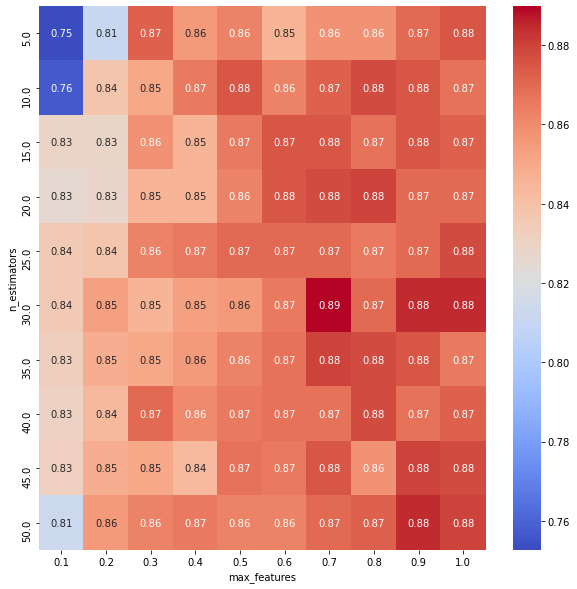

In [34]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

In [35]:
clf1 = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
clf2 = SVC(probability=True)
clf3 = GaussianNB()

c = VotingClassifier(estimators=[('randsubspace', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('randsubspace hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('randsubspace svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2),('gnb', clf3)], voting='hard')
cc = c.fit(x_train, y_train)
print('randsubspace svc gnb hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randsubspace', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('randsubspace soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('randsubspace svc soft',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randsubspace', clf1),('svc', clf2),('gnb', clf3)], voting='soft')
cc = c.fit(x_train, y_train)
print('randsubspace svc gnb soft',cc.score(x_test, y_test))

randsubspace hard 0.8651960784313726
svc hard 0.8848039215686274
randsubspace svc hard 0.8848039215686274
randsubspace svc gnb hard 0.8578431372549019
randsubspace soft 0.8431372549019608
svc soft 0.8799019607843137
randsubspace svc soft 0.8774509803921569
randsubspace svc gnb soft 0.8529411764705882


4. Sprawdzić jak działa RandomPatches dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej wielkości pozdzbioru danych i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [36]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8480392156862745

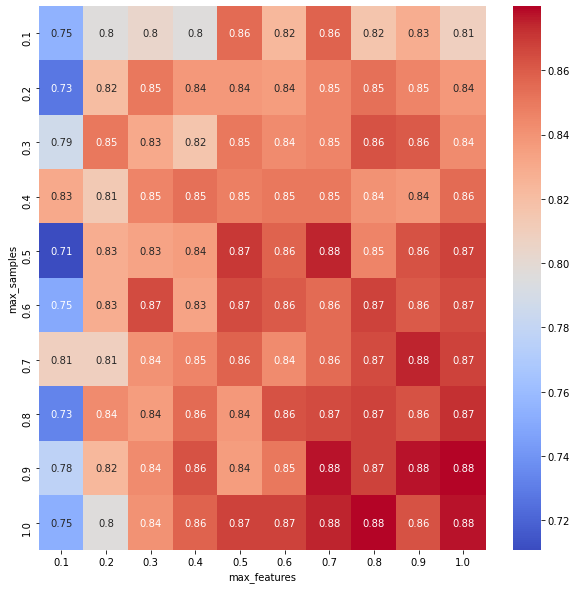

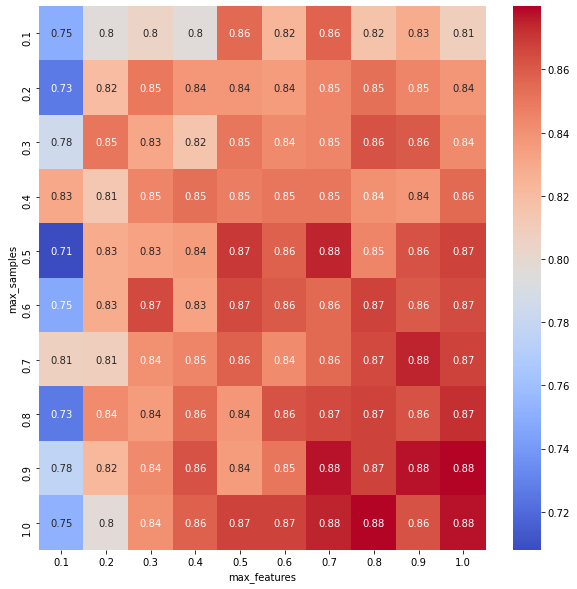

In [37]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

In [38]:
clf1 = classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
clf2 = SVC(probability=True)
clf3 = GaussianNB()

c = VotingClassifier(estimators=[('randpatches', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('randpatches hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randpatches', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('randpatches svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('ranpatches', clf1),('svc', clf2),('gnb', clf3)], voting='hard')
cc = c.fit(x_train, y_train)
print('randpatches svc gnb hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('randpatches', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('randpatches soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('randpatches', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('randpatches svc soft',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('ranpatches', clf1),('svc', clf2),('gnb', clf3)], voting='soft')
cc = c.fit(x_train, y_train)
print('randpatches svc gnb soft',cc.score(x_test, y_test))

randpatches hard 0.8602941176470589
svc hard 0.8848039215686274
randpatches svc hard 0.8578431372549019
randpatches svc gnb hard 0.8651960784313726
randpatches soft 0.8431372549019608
svc soft 0.8799019607843137
randpatches svc soft 0.8700980392156863
randpatches svc gnb soft 0.8578431372549019


5. Sprawdzić jak działa AdaBoost dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów

In [39]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8063725490196079

In [40]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.806373,0.806343
1,10.0,0.833333,0.833413
2,15.0,0.850490,0.850468
3,20.0,0.855392,0.855475
4,25.0,0.845588,0.845647
5,30.0,0.843137,0.843269
6,35.0,0.855392,0.855509
7,40.0,0.867647,0.867758
8,45.0,0.862745,0.862811
9,50.0,0.862745,0.862851


In [41]:
result.score.max(), result.score.idxmax()

(0.8676470588235294, 7)

In [42]:
result.score_f1.max(), result.score_f1.idxmax()

(0.8677584375578993, 7)

6. Sprawdzić jak działa RandomForest dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory

In [43]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8357843137254902

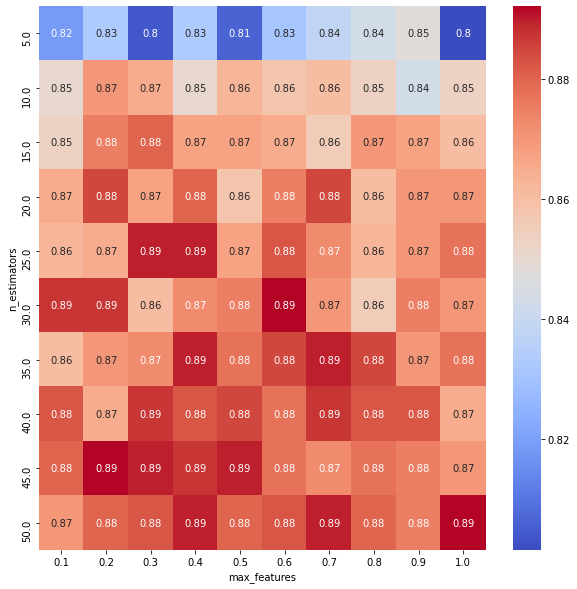

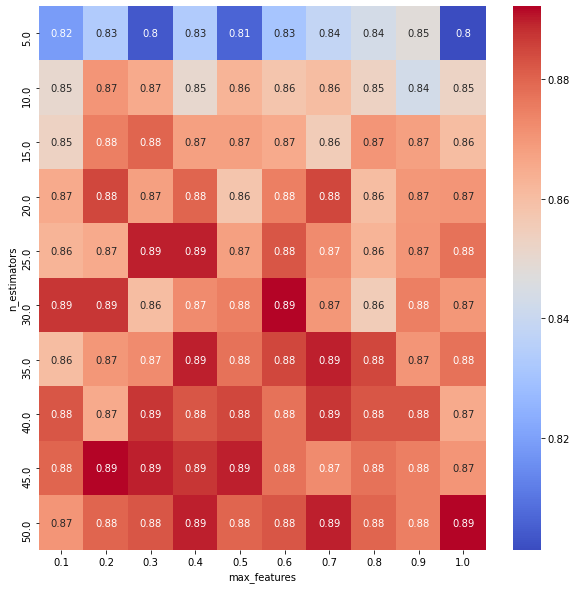

In [44]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')